# **Tutorial 7**


### Imports

In [1]:
import numpy as np # arrays, array operations
import scipy.stats as stats # statistics
from google.colab import files
import matplotlib.pyplot as plt # plot graphs
import pandas as pd #dataframes
import io
import xarray as xr #multidimensional dataframes
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.interpolate as interpolate

#preliz
!pip install preliz
import preliz as pz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 8.6 MB/s eta 0:00:00


### Data

In [2]:

uploaded = files.upload()

data = pd.read_csv(io.BytesIO(uploaded['muscle_force.csv']))

for col in data.columns: # see names of the columns in a loop
    print(col)

Saving muscle_force.csv to muscle_force.csv
Force
Length


In [13]:
#changing the data
data2 = data

data2.Force = data2.Force + data2.Length*np.random.normal(0, 5, len(data))

plt.scatter(data2.Length, data2.Force)


,Force,Length
0,56.101451,1
1,55.626065,1
2,54.345806,1
3,59.797048,1
4,114.873397,2
5,104.181233,2
6,108.780104,3
7,135.128194,3
8,206.279789,4
9,158.535717,4


In [14]:

df = pd.concat([data, data2],ignore_index=True)
plt.scatter(df.Length, df.Force)
data = df

,Force,Length
0,56.101451,1
1,55.626065,1
2,54.345806,1
3,59.797048,1
4,114.873397,2
5,104.181233,2
6,108.780104,3
7,135.128194,3
8,206.279789,4
9,158.535717,4


Plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

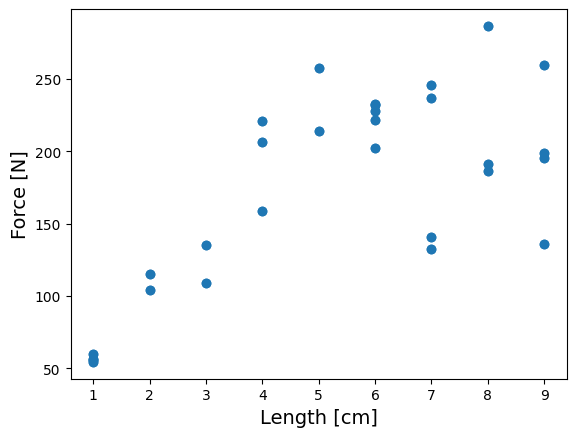

In [5]:
plt.scatter(data.Length, data.Force)

plt.xlabel('Length [cm]', fontsize = 14)
plt.ylabel('Force [N]', fontsize = 14)
plt.savefig("muscle.png", bbox_inches='tight')
files.download("muscle.png")


### Simple Linear Regression

Model

In [15]:
coords = {"data": np.arange(len(data))}
with pm.Model(coords=coords) as model_slr:
    b0 = pm.Normal("b0", mu=50, sigma=50)
    b1 = pm.Normal("b1", mu=0, sigma=50)
    sig = pm.HalfNormal("sig", 10)
    mu = pm.Deterministic("mu", b0 + b1 * data.Length, dims="data")
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sig, observed=data.Force, dims="data")

    idata_slr = pm.sample(1000, chains = 4)

idata_slr

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Posterior Data

In [12]:
az.plot_posterior(idata_slr, var_names=["~mu"], figsize=(12, 3))
plt.savefig("post.png", bbox_inches='tight')
files.download("post.png")

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

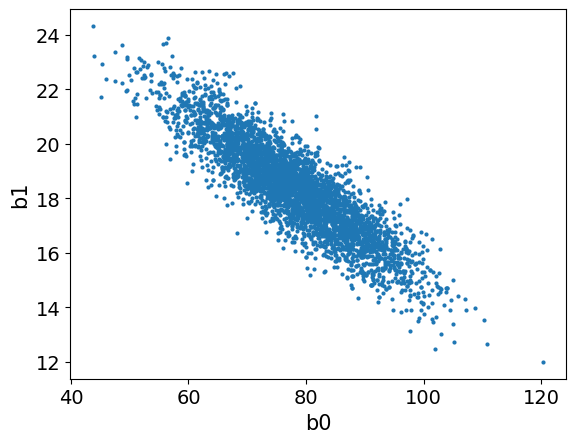

In [ ]:
#pair plot
az.plot_pair(idata_slr, var_names=['b0', 'b1'])
plt.savefig("pair.png", bbox_inches='tight')
files.download("pair.png")

Looking at distributions of the mean for different muscle lengths

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

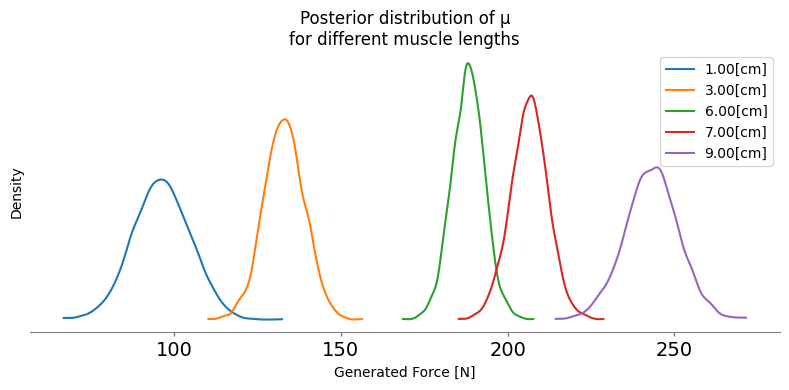

In [ ]:
# Define percentiles to calculate
percentiles = [5, 25, 50, 75, 95]

# Initialize list to store indexes
percentile_idxs = []

# Create figure with subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharey=True)

# Calculate percentile indices
for i,p in enumerate(percentiles):
    # Calculate the percentile value
    p_value = np.percentile(data.Length, p)

    # Find index where temperature is closest to this value
    idx = np.abs(data.Length - p_value).argmin()

    # Store this index
    percentile_idxs.append(idx)
    mu_posterior = idata_slr.posterior["mu"].sel(data=idx)

    len_value = data.Length.iloc[idx]

    # Plot the posterior distribution
    az.plot_posterior(mu_posterior, ax=axes, point_estimate=None,
        hdi_prob="hide", label=f"{len_value:.2f}[cm]",
        color=f"C{i}")

    axes.set_xlabel('Generated Force [N]')
    axes.set_ylabel('Density')
    axes.set_title(f"Posterior distribution of μ\nfor different muscle lengths")


plt.tight_layout()

plt.savefig("mus.png", bbox_inches='tight')
files.download("mus.png")

Lines

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

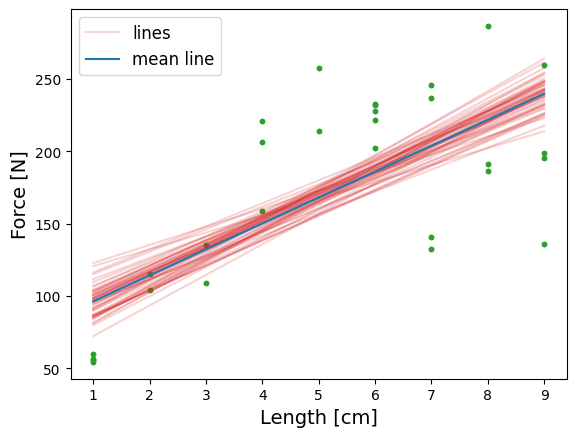

In [45]:
posterior = az.extract(idata_slr, num_samples=50)
x_plot = xr.DataArray(np.linspace(data.Length.min(), data.Length.max(), len(data.Force)), dims="plot_id")

mean_line = posterior["b0"].mean() + posterior["b1"].mean() * x_plot
lines = posterior["b0"] + posterior["b1"] * x_plot

plt.plot(data.Length, data.Force, "C2.")
lines_ = plt.plot(x_plot, lines.T, c="C3", alpha=0.2, label="lines")
plt.setp(lines_[1:], label="_")
plt.plot(x_plot, mean_line, c="C0", label="mean line")
plt.xlabel('Length [cm]', fontsize = 14)
plt.ylabel('Force [N]', fontsize = 14)
plt.legend(fontsize = 12)


plt.savefig("lines.png", bbox_inches='tight')
files.download("lines.png")

HDI

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

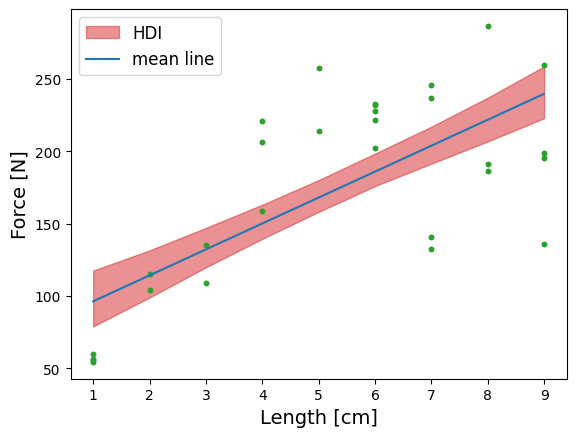

In [47]:
hdi_lines = az.hdi(idata_slr.posterior["mu"])

plt.plot(data.Length, data.Force, "C2.")
idx = np.argsort(data.Length.values)
plt.fill_between(
    data.Length[idx],
    hdi_lines["mu"][:, 0][idx],
    hdi_lines["mu"][:, 1][idx],
    color="C3",
    label="HDI",
    alpha=0.5)

plt.plot(x_plot, mean_line, c="C0", label="mean line")
plt.xlabel('Length [cm]', fontsize = 14)
plt.ylabel('Force [N]', fontsize = 14)
plt.legend(fontsize = 12)

plt.savefig("hdi.png", bbox_inches='tight')
files.download("hdi.png")

Posterior Predictive

In [ ]:
pm.sample_posterior_predictive(idata_slr, model=model_slr, extend_inferencedata=True)


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

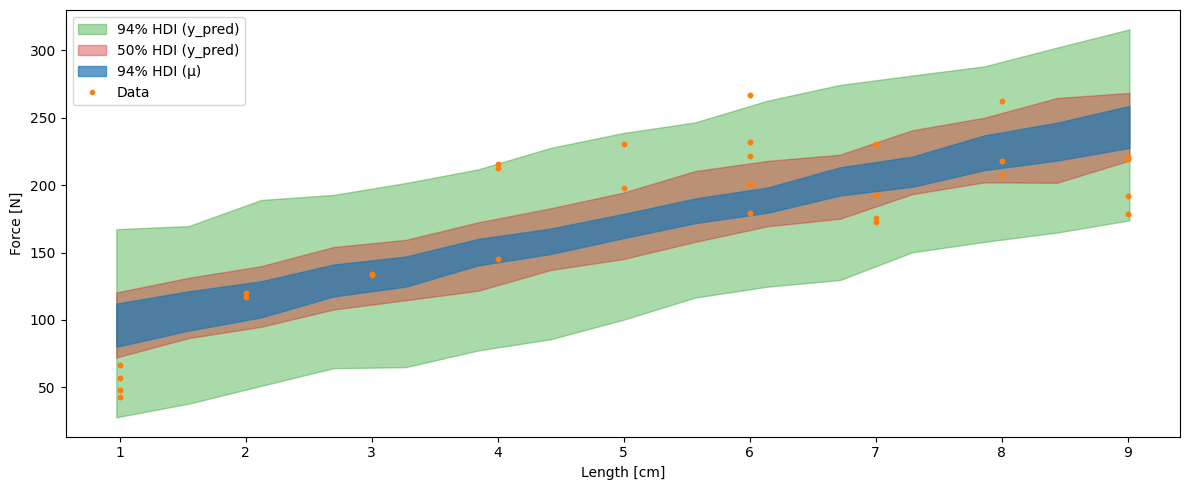

In [ ]:
# Setup
lengths = np.random.normal(data.Length, 0.01)
idx = np.argsort(lengths)
x = np.linspace(lengths.min(), lengths.max(), 15)

HDIs_pp = [0.94, 0.5]  # Multiple HDIs for posterior predictive
HDI_mu = 0.94          # Single HDI for posterior μ

# --- Posterior Predictive HDIs ---
pp_percentiles = []
for hdi in HDIs_pp:
    p_low = (1 - hdi) / 2
    p_high = 1 - p_low
    pp_percentiles.extend([p_low, p_high])

y_pred_q = idata_slr.posterior_predictive["y_pred"].quantile(pp_percentiles, dim=["chain", "draw"])

# Interpolated HDI bounds for y_pred
y_hat_bounds = {}
for i, hdi in enumerate(HDIs_pp):
    lb = y_pred_q[2 * i]
    ub = y_pred_q[2 * i + 1]
    y_hat_bounds[hdi] = (
        interpolate.PchipInterpolator(lengths[idx], lb[idx])(x),
        interpolate.PchipInterpolator(lengths[idx], ub[idx])(x)
    )

# --- Posterior μ HDI ---
p_low_mu = (1 - HDI_mu) / 2
p_high_mu = 1 - p_low_mu
mu_q = idata_slr.posterior["mu"].quantile([p_low_mu, p_high_mu], dim=["chain", "draw"])

mu_bounds = (
    interpolate.PchipInterpolator(lengths[idx], mu_q[0][idx])(x),
    interpolate.PchipInterpolator(lengths[idx], mu_q[1][idx])(x)
)

# --- Plot ---
_, ax = plt.subplots(figsize=(12, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Fill posterior predictive HDIs
for i, hdi in enumerate(HDIs_pp):
    lb, ub = y_hat_bounds[hdi]
    ax.fill_between(x, lb, ub, color=colors[i % len(colors)+2], alpha=0.4, label=f"{int(hdi*100)}% HDI (y_pred)", zorder=i)

# Fill μ HDI
mu_color = 'C0'
ax.fill_between(x, *mu_bounds, color=mu_color, alpha=0.7, label=f"{int(HDI_mu*100)}% HDI (μ)", zorder=len(HDIs_pp))

# Data points
ax.plot(data.Length, data.Force, "C1.", label="Data", zorder=len(HDIs_pp)+1)

ax.set_xlabel("Length [cm]")
ax.set_ylabel("Force [N]")
ax.legend()
plt.tight_layout()

plt.savefig("pp.png", bbox_inches='tight')
files.download("pp.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

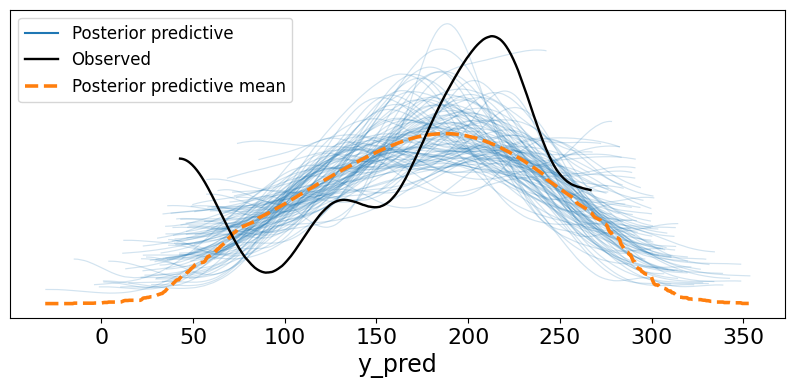

In [ ]:
#plotting
az.plot_ppc(idata_slr, figsize=(10, 4), num_pp_samples=100)
plt.savefig("posterior_predictive.png", bbox_inches='tight')
files.download("posterior_predictive.png")

Prior Predictive

In [ ]:
with model_slr:
  prior_predictive = pm.sample_prior_predictive(1000)

prior_predictive

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1000x600 with 0 Axes>

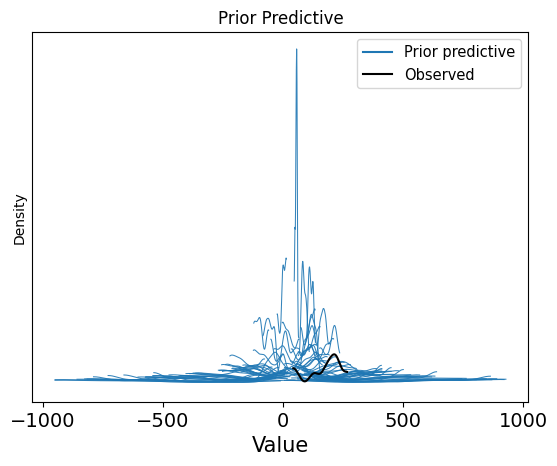

In [ ]:
#a lot of examples
plt.figure(figsize=(10, 6))
ax = az.plot_ppc(prior_predictive, group='prior', num_pp_samples=100, mean=False, observed=True)

for l in ax.get_lines()[2:]:
    l.set_alpha(0.9)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Prior Predictive')

plt.savefig("prior_predictive2.png", bbox_inches='tight')
files.download("prior_predictive2.png")

Bayesian p-value

<Axes: title={'center': 'y_pred'}>

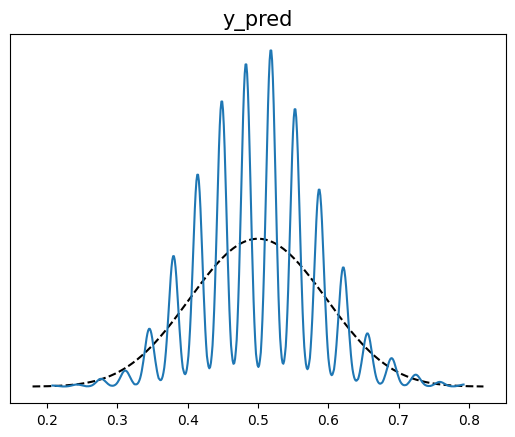

In [ ]:
#distribution
az.plot_bpv(idata_slr, kind="p_value")

plt.savefig("p.png", bbox_inches='tight')
files.download("p.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

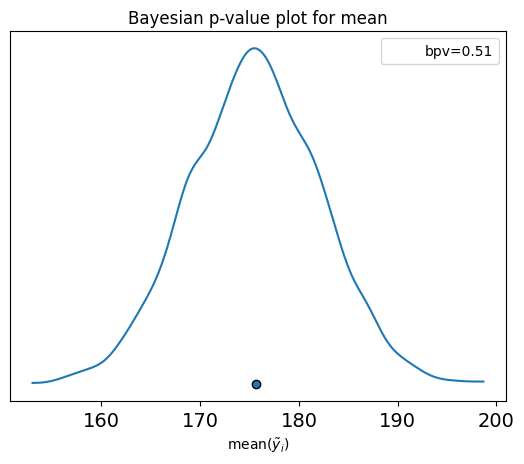

In [ ]:
#statistics
#mean
ax = az.plot_bpv(idata_slr, kind="t_stat", t_stat="mean")
ax.set_title("Bayesian p-value plot for mean")
ax.set_xlabel(r"mean($\tilde{y}_{i}$)")

plt.savefig("pm.png", bbox_inches='tight')
files.download("pm.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

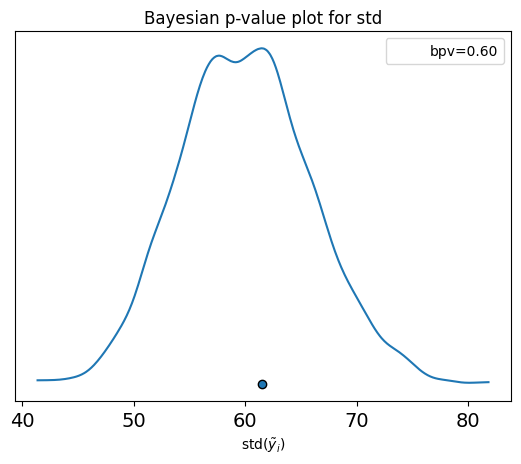

In [ ]:
#std
ax = az.plot_bpv(idata_slr, kind="t_stat", t_stat="std")
ax.set_title("Bayesian p-value plot for std")
ax.set_xlabel(r"std($\tilde{y}_{i}$)")

plt.savefig("ps.png", bbox_inches='tight')
files.download("ps.png")

### Data Transformation

In [ ]:
coords = {"data": np.arange(len(data))}
with pm.Model(coords=coords) as model_nlr:
    b0 = pm.Normal("b0", mu=50, sigma=50)
    b1 = pm.Normal("b1", mu=0, sigma=50)
    sig = pm.HalfNormal("sig", 10)
    mu = pm.Deterministic("mu", b0 + b1 * np.log(data.Length), dims="data")
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sig, observed=data.Force, dims="data")

    idata_nlr = pm.sample(1000, chains = 4)

idata_nlr

Output()

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Posterior

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

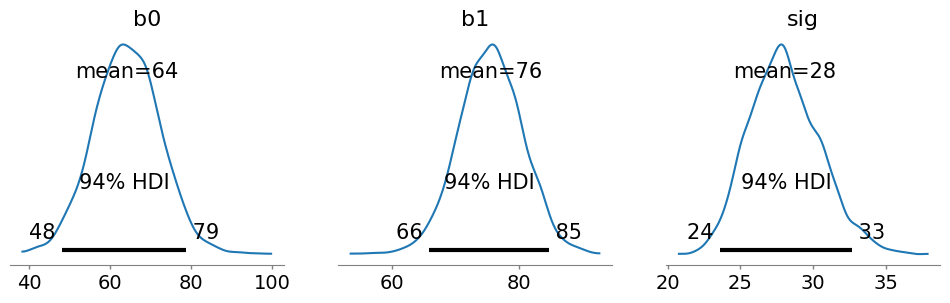

In [ ]:
az.plot_posterior(idata_nlr, var_names=["~mu"], figsize=(12, 3))
plt.savefig("post2.png", bbox_inches='tight')
files.download("post2.png")

Lines

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

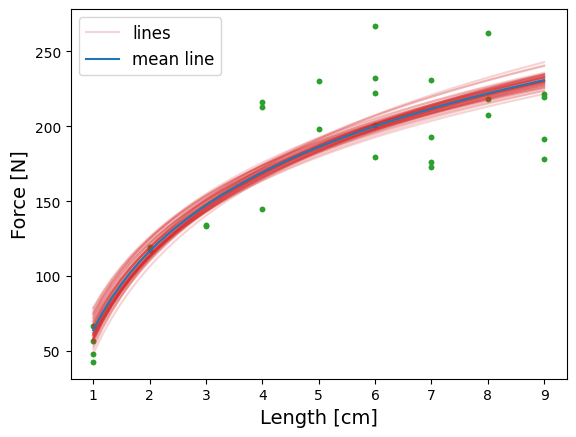

In [ ]:
posterior = az.extract(idata_nlr, num_samples=50)
x_plot = xr.DataArray(np.linspace(data.Length.min(), data.Length.max(), 50), dims="plot_id")

mean_line = posterior["b0"].mean() + posterior["b1"].mean() * np.log(x_plot)
lines = posterior["b0"] + posterior["b1"] * np.log(x_plot)

plt.plot(data.Length, data.Force, "C2.")
lines_ = plt.plot(x_plot, lines.T, c="C3", alpha=0.2, label="lines")
plt.setp(lines_[1:], label="_")
plt.plot(x_plot, mean_line, c="C0", label="mean line")
plt.xlabel('Length [cm]', fontsize = 14)
plt.ylabel('Force [N]', fontsize = 14)
plt.legend(fontsize = 12)


plt.savefig("lines2.png", bbox_inches='tight')
files.download("lines2.png")

HDI

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

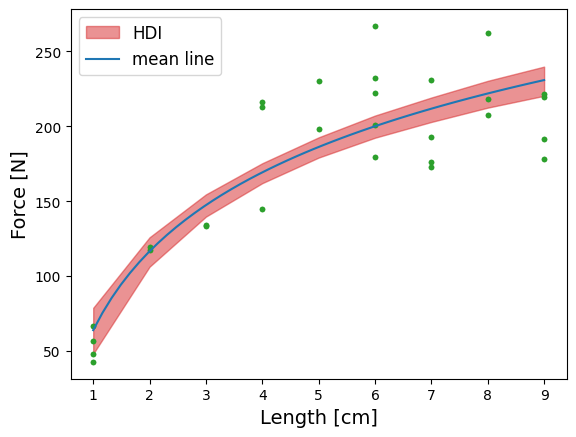

In [ ]:
hdi_lines = az.hdi(idata_nlr.posterior["mu"])

plt.plot(data.Length, data.Force, "C2.")
idx = np.argsort(data.Length.values)
plt.fill_between(
    data.Length[idx],
    hdi_lines["mu"][:, 0][idx],
    hdi_lines["mu"][:, 1][idx],
    color="C3",
    label="HDI",
    alpha=0.5)

plt.plot(x_plot, mean_line, c="C0", label="mean line")
plt.xlabel('Length [cm]', fontsize = 14)
plt.ylabel('Force [N]', fontsize = 14)
plt.legend(fontsize = 12)

plt.savefig("hdi2.png", bbox_inches='tight')
files.download("hdi2.png")

Posterior Predictive

In [ ]:
pm.sample_posterior_predictive(idata_nlr, model=model_nlr, extend_inferencedata=True)


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

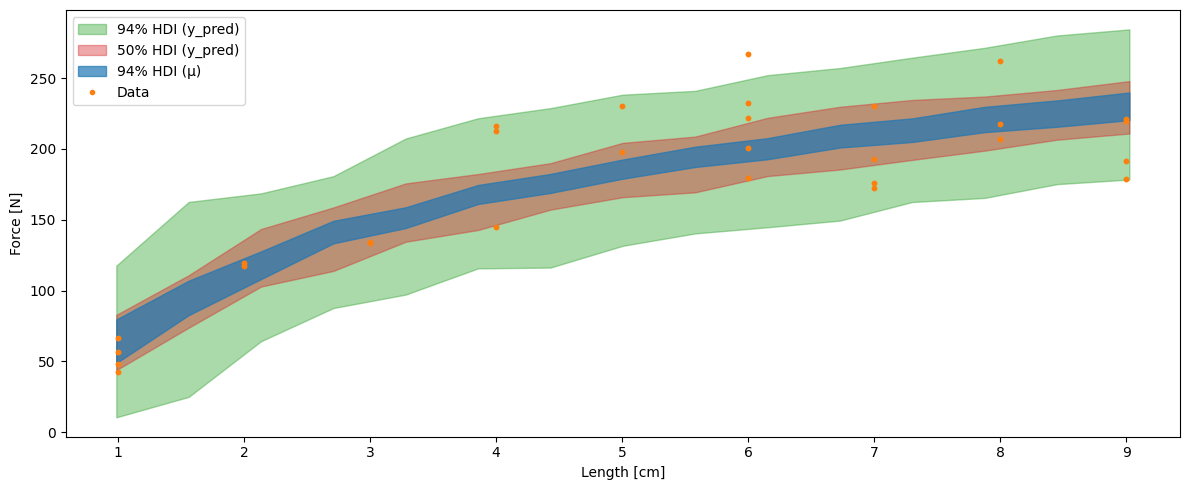

In [ ]:
# Setup
lengths = np.random.normal(data.Length, 0.01)
idx = np.argsort(lengths)
x = np.linspace(lengths.min(), lengths.max(), 15)

HDIs_pp = [0.94, 0.5]  # Multiple HDIs for posterior predictive
HDI_mu = 0.94          # Single HDI for posterior μ

# --- Posterior Predictive HDIs ---
pp_percentiles = []
for hdi in HDIs_pp:
    p_low = (1 - hdi) / 2
    p_high = 1 - p_low
    pp_percentiles.extend([p_low, p_high])

y_pred_q = idata_nlr.posterior_predictive["y_pred"].quantile(pp_percentiles, dim=["chain", "draw"])

# Interpolated HDI bounds for y_pred
y_hat_bounds = {}
for i, hdi in enumerate(HDIs_pp):
    lb = y_pred_q[2 * i]
    ub = y_pred_q[2 * i + 1]
    y_hat_bounds[hdi] = (
        interpolate.PchipInterpolator(lengths[idx], lb[idx])(x),
        interpolate.PchipInterpolator(lengths[idx], ub[idx])(x)
    )

# --- Posterior μ HDI ---
p_low_mu = (1 - HDI_mu) / 2
p_high_mu = 1 - p_low_mu
mu_q = idata_nlr.posterior["mu"].quantile([p_low_mu, p_high_mu], dim=["chain", "draw"])

mu_bounds = (
    interpolate.PchipInterpolator(lengths[idx], mu_q[0][idx])(x),
    interpolate.PchipInterpolator(lengths[idx], mu_q[1][idx])(x)
)

# --- Plot ---
_, ax = plt.subplots(figsize=(12, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Fill posterior predictive HDIs
for i, hdi in enumerate(HDIs_pp):
    lb, ub = y_hat_bounds[hdi]
    ax.fill_between(x, lb, ub, color=colors[i % len(colors)+2], alpha=0.4, label=f"{int(hdi*100)}% HDI (y_pred)", zorder=i)

# Fill μ HDI
mu_color = 'C0'
ax.fill_between(x, *mu_bounds, color=mu_color, alpha=0.7, label=f"{int(HDI_mu*100)}% HDI (μ)", zorder=len(HDIs_pp))

# Data points
ax.plot(data.Length, data.Force, "C1.", label="Data", zorder=len(HDIs_pp)+1)

ax.set_xlabel("Length [cm]")
ax.set_ylabel("Force [N]")
ax.legend()
plt.tight_layout()

plt.savefig("pp2.png", bbox_inches='tight')
files.download("pp2.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

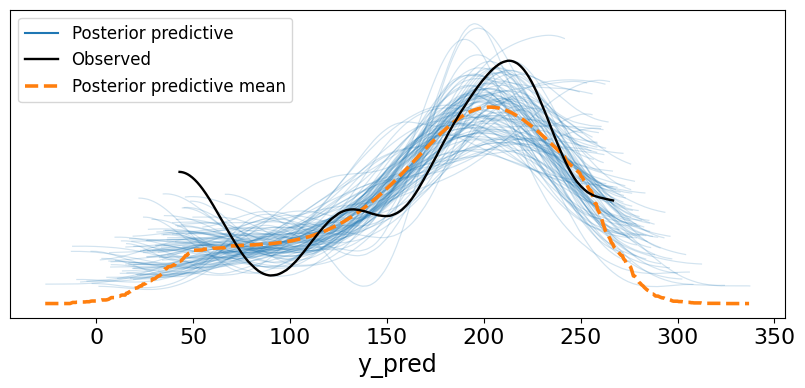

In [ ]:
#plotting
az.plot_ppc(idata_nlr, figsize=(10, 4), num_pp_samples=100)
plt.savefig("posterior_predictive2.png", bbox_inches='tight')
files.download("posterior_predictive2.png")

Bayesian p-value

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

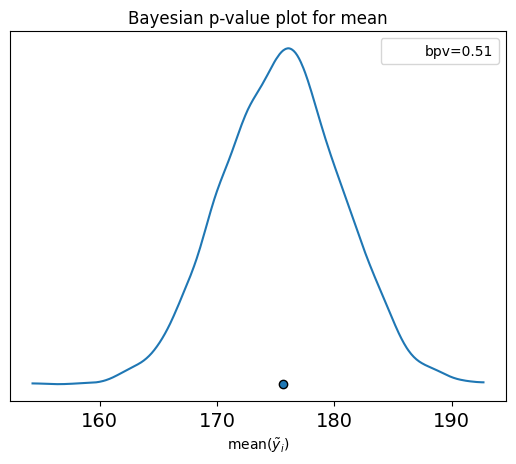

In [ ]:
#distribution
#mean
ax = az.plot_bpv(idata_nlr, kind="t_stat", t_stat="mean")
ax.set_title("Bayesian p-value plot for mean")
ax.set_xlabel(r"mean($\tilde{y}_{i}$)")

plt.savefig("pm2.png", bbox_inches='tight')
files.download("pm2.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

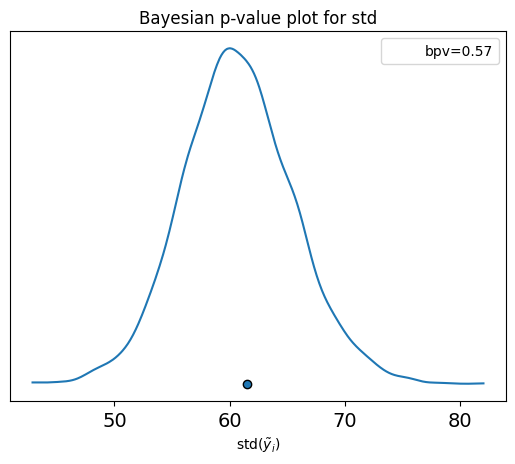

In [ ]:
#std
ax = az.plot_bpv(idata_nlr, kind="t_stat", t_stat="std")
ax.set_title("Bayesian p-value plot for std")
ax.set_xlabel(r"std($\tilde{y}_{i}$)")

plt.savefig("ps2.png", bbox_inches='tight')
files.download("ps2.png")

### Heteroskedcticity

In [ ]:
sorted_df = data.sort_values(by='Length')
data = sorted_df
coords = {"length": range(len(data.Length))}
with pm.Model(coords=coords) as model_vv:
    x_shared = pm.Data("x_shared", data.Length, dims=["length"])
    b0 = pm.Normal("b0", mu=50, sigma=50)
    b1 = pm.Normal("b1", mu=0, sigma=50)

    a0 = pm.HalfNormal("a0", sigma=20)
    a1 = pm.HalfNormal("a1", sigma=20)

    mu = pm.Deterministic("mu", b0 + b1 * np.log(x_shared), dims="length")
    sig = pm.Deterministic("sig", a0 + a1 * x_shared, dims="length")

    y_pred = pm.Normal("y_pred", mu=mu, sigma=sig, observed=data.Force, dims="length")

    idata_vv = pm.sample(1000, chains = 4, target_accept = 0.95)


Output()

Posterior

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

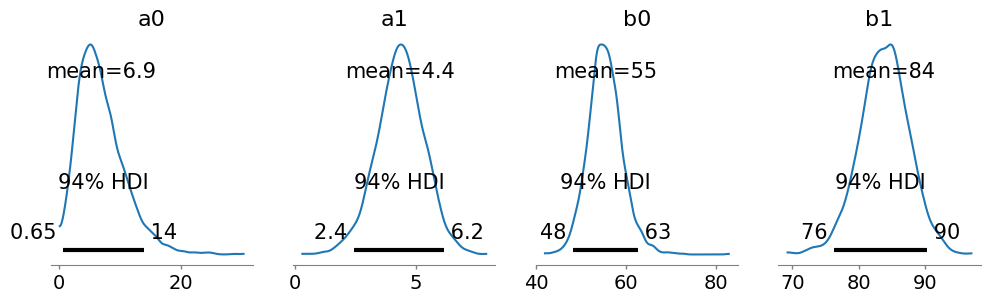

In [ ]:
az.plot_posterior(idata_vv, var_names=["~mu", '~sig'], figsize=(12, 3))
plt.savefig("post3.png", bbox_inches='tight')
files.download("post3.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

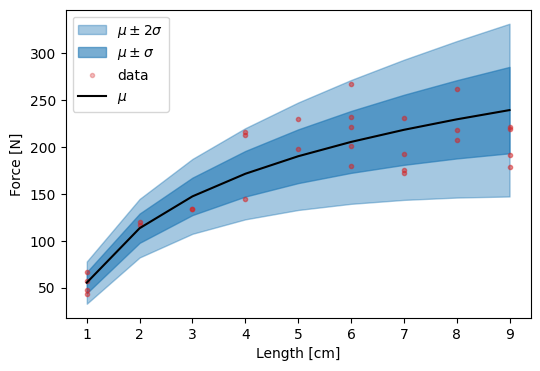

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(6, 4))

posterior = az.extract(idata_vv)

μ_m = posterior["mu"].mean("sample").values
σ_m = posterior["sig"].mean("sample").values

ax.fill_between(data.Length, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C0", label=r"$\mu \pm 2 \sigma$")
ax.fill_between(data.Length, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C0", label=r"$\mu \pm \sigma$")
plt.plot(data.Length, data.Force, "C3.", alpha=0.3, label="data")
plt.plot(data.Length, μ_m, c="k", label=r"$\mu$")

ax.legend()
ax.set_xlabel("Length [cm]")
ax.set_ylabel("Force [N]")

plt.savefig("post4.png", bbox_inches='tight')
files.download("post4.png")